# Lecture 12 - Dimensionality Reduction of Gaussian Random Fields

## Objectives

+ to reduce the dimensionality of a Gaussian random field
+ to build a Gaussian random field from data
+ to efficient implementation of Gaussian random fields in two and three dimensions

# Readings
There is not really an easy way into this topic, but here are some references in case you are interested:
+ Ghanem, Roger; Spanos, Pol (1991). Stochastic finite elements: a spectral approach. Springer-Verlag. ISBN 0-387-97456-3.
+ Betz, W., Papaioannou, I., & Straub, D. (2014). Numerical methods for the discretization of random fields by means of the Karhunen-Loeve expansion. Computer Methods in Applied Mechanics and Engineering, 271, 109-129. doi:10.1016/j.cma.2013.12.010

## Karhunen-Loeve Expansion

Consider a Gaussian process:
\begin{equation}
f(\cdot) | m(\cdot), k(\cdot, \cdot) \sim \mbox{GP}\left(f(\cdot) | m(\cdot), k(\cdot, \cdot) \right),
\end{equation}
where 
$m(\cdot)$ is the mean function and 
$k(\cdot,\cdot)$ is the covariance function.
The *Karhunen-Loève expansion* (KLE) of $f(\cdot)$ allows us to write it as:
\begin{equation}
f(\mathbf{x}) = m(\mathbf{x}) + \sum_{i=1}^{\infty}\xi_i \sqrt{\lambda_i} \phi_i(\mathbf{x}),
\end{equation}
where the random variables
\begin{equation}
\xi \sim \mathcal{N}(\xi|0, 1)
\end{equation}
are independent, and $\lambda_i$ and $\phi_i(\mathbf{x})$ are the eigenvalues and
eigenvectors, respectively, of the covariance function, i.e.,
\begin{equation}
\int k(\mathbf{x}, \mathbf{x}') \phi_i(\mathbf{x}')d\mathbf{x}' = \lambda_i \phi_i(\mathbf{x}').
\end{equation}
Since $k(\cdot, \cdot)$ is actually positive definite, the eigenvalues are all positive
and the eigenfunctions are orthogonal:
$$
\int \phi_i(\mathbf{x})\phi_j(\mathbf{x}')d\mathbf{x} = \delta_{ij}.
$$

### Truncated KLE
Usually, we truncate the KLE to a finite order $M$, i.e., we write
\begin{equation}
f(\mathbf{x}) \approx f_M(\mathbf{x}) = m(\mathbf{x}) + \sum_{i=1}^M \xi_i \sqrt{\lambda_i}\phi_i(\mathbf{x}).
\end{equation}
But how do we pick $M$ in practice?

In order to answer this question, notice that the variance of the field at the point $\mathbf{x}$ is given by:
$$
\mathbf{V}[f(\mathbf{x})] = \sum_{i=1}^{\infty}\lambda_i\phi_i^2(\mathbf{x})
$$
The *energy* of the field, $\mathcal{E}[f(\cdot)]$ is defined to be:
\begin{equation}
\mathcal{E}[f(\cdot)] := \int\mathbb{V}[f(\mathbf{x})]d\mathbf{x} = \sum_{i=1}^\infty \lambda_i,
\end{equation}
where we have used the orthonormality of the $\phi(\cdot)$'s.
The energy of the field is a measure of the total variance of the field.
The idea is to select $M$ so that the energy of the truncated field $f_M(\cdot)$ is as
captures a percentage $\alpha$ of the energy of the original field.
That is, we pick $M$ so that
$$
\mathcal{E}[f_M(\cdot)] = \alpha\mathcal{E}[f(\cdot)],
$$
or
$$
\sum_{i=1}^M\lambda_i = \alpha \sum_{i=1}^\infty \lambda_i.
$$
Typically, $\alpha = 0.95$.

### Why is this useful?
The KLE allows us to reduce the dimensionality of random fields.
This is extremely useful in uncertainty propagation and model calibration tasks.
For example, in uncertainty propagation, by employing the KLE one has to deal with
a finite set of Gaussian random variables $\xi_i$ instead of an infinitely dimensional
Gaussian random field.

In [7]:
import numpy as np
import scipy

class KarhunenLoeveExpansion(object):
    
    """
    A class representing the Karhunen Loeve Expansion of a Gaussian random field.
    It uses the Nystrom approximation to do it.
    
    Arguments:
        k      -     The covariance function.
        Xq     -     Quadrature points for the Nystrom approximation.
        wq     -     Quadrature weights for the Nystrom approximation.
        alpha  -     The percentage of the energy of the field that you want to keep.
        X      -     Observed inputs (optional).
        Y      -     Observed field values (optional).
    """
    
    def __init__(self, k, Xq=None, wq=None, nq=100, alpha=0.9, X=None, Y=None):
        self.k = k
        if Xq is None:
            if k.input_dim == 1:
                Xq = np.linspace(0, 1, nq)[:, None]
                wq = np.ones((nq, )) / nq
            elif k.input_dim == 2:
                nq = int(np.sqrt(nq))
                x = np.linspace(0, 1, nq)
                X1, X2 = np.meshgrid(x, x)
                Xq = np.hstack([X1.flatten()[:, None], X2.flatten()[:, None]])
                wq = np.ones((nq ** 2, )) / nq ** 2
            else:
                raise NotImplementedError('For more than 2D, please supply quadrature points and weights.')
        self.Xq = Xq
        self.wq = wq
        self.k = k
        self.alpha = alpha
        self.X = X
        self.Y = Y
        # If we have some observed data, we need to use the posterior covariance
        if X is not None:
            gpr = GPy.models.GPRegression(X, Y[:, None], k)
            gpr.likelihood.variance = 1e-12
            self.gpr = gpr
            Kq = gpr.predict(Xq, full_cov=True)[1]
        else:
            Kq = k.K(Xq)
        B = np.einsum('ij,j->ij', Kq, wq)
        lam, v = scipy.linalg.eigh(B, overwrite_a=True)
        lam = lam[::-1]
        lam[lam <= 0.] = 0.
        energy = np.cumsum(lam) / np.sum(lam)
        i_end = np.arange(energy.shape[0])[energy > alpha][0] + 1
        lam = lam[:i_end]
        v = v[:, ::-1]
        v = v[:, :i_end]
        self.lam = lam
        self.sqrt_lam = np.sqrt(lam)
        self.v = v
        self.energy = energy
        self.num_xi = i_end
        
    def eval_phi(self, x):
        """
        Evaluate the eigenfunctions at x.
        """
        if self.X is not None:
            nq = self.Xq.shape[0]
            Xf = np.vstack([self.Xq, x])
            m, C = self.gpr.predict(Xf, full_cov=True)
            Kc = C[:nq, nq:].T
            self.tmp_mu = m[nq:, :].flatten()
        else:
            Kc = self.k.K(x, self.Xq)
            self.tmp_mu = 0.
        phi = np.einsum('i,ji,j,rj->ri', 1. / self.lam, self.v, self.wq, Kc)
        return phi
    
    def __call__(self, x, xi):
        """
        Evaluate the expansion at x and xi.
        """
        phi = self.eval_phi(x)
        return self.tmp_mu + np.dot(phi, xi * self.sqrt_lam)

Let's just plot the eigenfunctions/values of the square exponential covariance function:

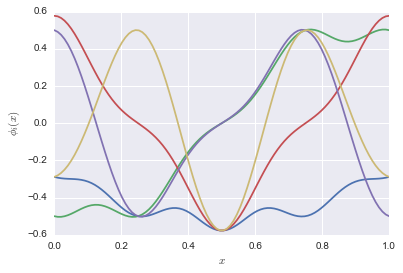

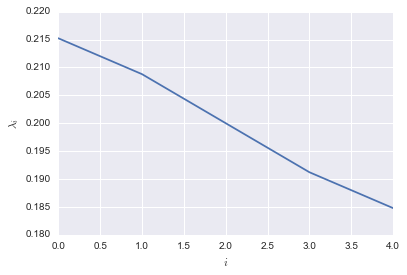

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import GPy
k = GPy.kern.RBF(1, lengthscale=0.1)
kle = KarhunenLoeveExpansion(k, nq=5, alpha=.9)
x = np.linspace(0, 1, 100)[:, None]
fig, ax = plt.subplots()
ax.plot(x, kle.eval_phi(x))
ax.set_xlabel('$x$')
ax.set_ylabel('$\phi_i(x)$')
fig, ax = plt.subplots()
ax.plot(kle.lam)
ax.set_xlabel('$i$')
ax.set_ylabel('$\lambda_i$');

### Questions

1. The estimated eigenfunctions and eigenvalues do not look very accurate. Perhaps, you need to increase the number of quadrature points used in the Nystrom approximation. Try ``nq=20``. How do they look now?

2. How are the eigenvalues of the covariance function affected if you decrease the lentghscale?

3. The default variance of the square exponential is one. Try changing it to 2. What changed, if anything?

4. Experiment with different covariance functions, e.g., the ``Exponential`` or the ``Matern32``.

### Varying the lengthscale
Let's vary the lengthscale of the SE and see what happens to the eigenvalues.

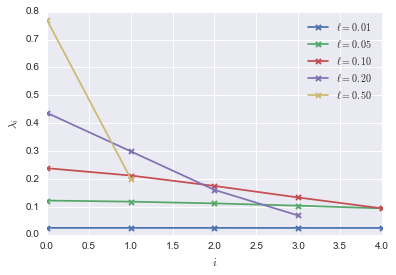

In [9]:
x = np.linspace(0, 1, 100)[:, None]
fig, ax = plt.subplots()
for ell in [0.01, 0.05, 0.1, 0.2, 0.5]:
    k = GPy.kern.RBF(1, lengthscale=ell)
    kle = KarhunenLoeveExpansion(k, nq=100, alpha=.9)
    ax.plot(kle.lam[:5], '-x', markersize=5, markeredgewidth=2, label='$\ell={0:1.2f}$'.format(ell))
plt.legend(loc='best')
ax.set_xlabel('$i$')
ax.set_ylabel('$\lambda_i$');

### Sampling from the random field using $\xi$

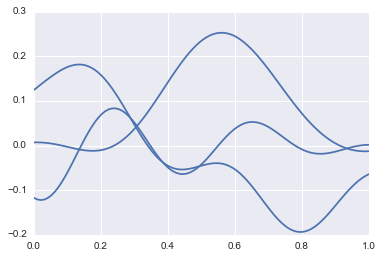

In [10]:
k = GPy.kern.Exponential(1, lengthscale=0.1)
kle = KarhunenLoeveExpansion(k, nq=100, alpha=0.8)
x = np.linspace(0, 1, 100)[:, None]
fig, ax = plt.subplots()
for i in xrange(3):
    xi = np.random.randn(kle.num_xi)
    f = kle(x, xi)
    plt.plot(x, f, color=sns.color_palette()[0])

### Questions
1. Above we show the samples that we get from the KLT using an exponential covariance function.
They look too smooth. The samples are supposed to be non-where differentiable. What is the problem?
2. How many terms did you need to get samples that really look like samples from an exponential GP?

### KLE for GP with Observed Data
Here we take a look at the KLE of a GP where we have made some input/output observations

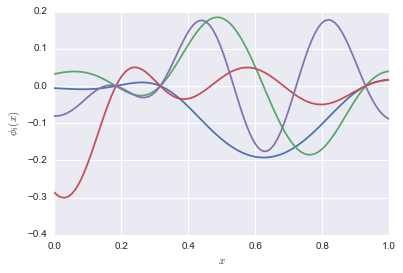

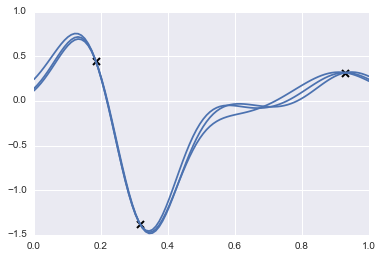

In [11]:
# Just generate some input/output pairs randomly...
np.random.seed(12345)
X = np.random.rand(3, 1)
Y = np.random.randn(3)
# X and Y are assumed to be observed

k = GPy.kern.RBF(1, lengthscale=0.1)
kle = KarhunenLoeveExpansion(k, nq=100, alpha=0.9, X=X, Y=Y)
x = np.linspace(0, 1, 100)[:, None]
fig, ax = plt.subplots()
ax.plot(x, kle.eval_phi(x))
ax.set_xlabel('$x$')
ax.set_ylabel('$\phi_i(x)$')
fig, ax = plt.subplots()
ax.plot(X, Y, 'kx', markeredgewidth=2)
for i in xrange(3):
    xi = np.random.randn(kle.num_xi)
    f = kle(x, xi)
    plt.plot(x, f, color=sns.color_palette()[0])

### Questions
1. What is the value of the basis functions at the points where we have observations?
2. Experiment with various covariance functions and hyper-parameters.

### Playing in two-dimensions
Let's experiment with these ideas in two dimensions.

Number of terms: 49


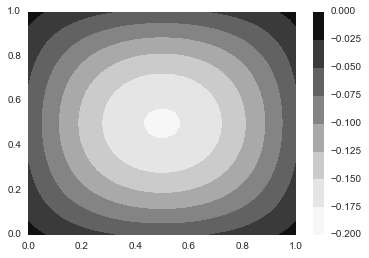

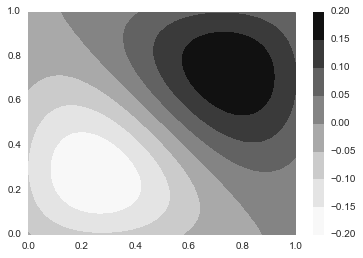

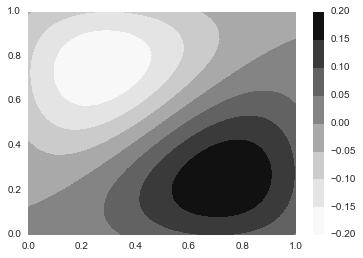

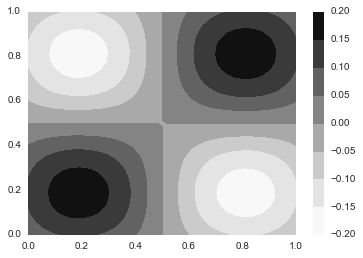

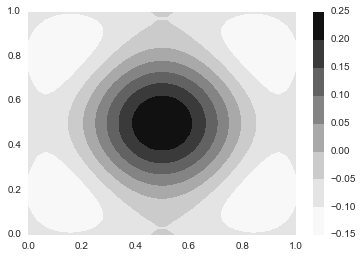

In [12]:
k = GPy.kern.RBF(2, lengthscale=0.1)
#X = np.random.rand(3, 2)
#Y = np.random.randn(3)
kle = KarhunenLoeveExpansion(k, nq=100, alpha=0.9)#, X=X, Y=Y)
x = np.linspace(0, 1, 32)
X1, X2 = np.meshgrid(x, x)
X_all = np.hstack([X1.flatten()[:, None], X2.flatten()[:, None]])
print 'Number of terms:', kle.num_xi
# Let's look at them
Phi = kle.eval_phi(X_all)
for i in xrange(5):
    fig, ax = plt.subplots()
    c = ax.contourf(X1, X2, Phi[:, i].reshape(X1.shape))
    #ax.plot(X[:, 0], X[:, 1], 'rx', markeredgewidth=2)
    plt.colorbar(c)

### Questions
1. Try plotting some eigenfunctions with higher index.
2. Try adding some observations.
3. Now, that you are getting familar, try to plot a few samples from this random field.